# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|OK|
|2. Attentional Seq2seq 모델이 정상적으로 구동된다.|seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|OK|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.|OK|

### dataset
1.[한영 병렬 데이터](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

### 적용 기법
1. GRU(Gated Recurrent Unit)
2. attention 기반의 Seq2seq 모델

## 문제 정의  

> Seq2seq with attention으로 한영 번역기 만들기

## 분석환경

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image
#Image(filename='test.jpg') 

In [2]:
import pandas
import tensorflow 
import matplotlib

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)
print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

2.6.0
1.3.3
2.6.0
3.4.3


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

완료!


## Step 1. 데이터 다운로드

* [한영 병렬 데이터](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [4]:
path_to_file = './data/korean-english-park.train.ko'
path_to_file_test = './data/korean-english-park.test.ko'

with open(path_to_file, "r") as f:
    raw_kor = f.read().splitlines()

print("Data Size:", len(raw_kor))

print("Example:")
for sen in raw_kor[0:100][::20]: print(">>", sen)
    
raw_kor[:5]

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
 '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
 '그러나 이것은 또한 책상도 필요로 하지 않는다.',
 '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
 '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.']

In [5]:
with open(path_to_file_test, "r") as f:
    raw_kor_test = f.read().splitlines()

print("Data Size:", len(raw_kor_test))

print("Example:")
for sen in raw_kor_test[0:100][::20]: print(">>", sen)
    
raw_kor_test[:5]

Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입하는 나라이며, 전적으로 원유 수입에 의존하고 있다.
>> 불과 1,379년 전이다.
>> 대신, 그들은 "안정"이라는 면에서 서방 세계와 똑같은 이해 관계를 갖고 있는 각 지역의 소수 엘리트를 대표하고 있다.


['토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.',
 '또한 새로운 기술 개발이 어떤 해결책을 제공해 주는데 도움이 될 것이고, 동시 에 통신망 사용자들이 보다 안전하게 통신을 할 수 있도록 도움을 주게 되리라는 희망도 있습니다.',
 '그래서 클리퍼 칩에 대한 개인적인 해결책은 서서히 자취를 감출 것입니다. 그러나 이 문제는 계속 우리 곁에 존재할 것이며, 당분간은 심각한 상태로 존재할 것입니다.',
 '이탈리아의 천문학자들이 멀리에 있는 별들의 궤도를 도는 행성의 대기에서 생명체의 필수 요소인 물이 존재한다는 징후를 발견했다.',
 '물이 있다는 것이 다른 행성에 생명체들이 가득하다는 것을 의미하지는 않지만, 이번 발견이 확인된다면 그런 일이 가능할 수 있다는 추측을 증폭시키게 될 것이다.']

In [6]:
path_to_file = './data/korean-english-park.train.en'
path_to_file_test = './data/korean-english-park.test.en'

with open(path_to_file, "r") as f:
    raw_en = f.read().splitlines()

print("Data Size:", len(raw_en))

print("Example:")
for sen in raw_en[0:100][::20]: print(">>", sen)


Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [7]:
with open(path_to_file_test, "r") as f:
    raw_en_test = f.read().splitlines()

print("Data Size:", len(raw_en_test))

print("Example:")
for sen in raw_en_test[0:100][::20]: print(">>", sen)

Data Size: 2000
Example:
>> Those involved in the discussions do take seriously the need to address concerns of law enforcement and national security.
>> Even though the threat is small, the potential effects are devastating.
>> South Korea is the world's fourth largest oil importer and wholly depends on imports of crude.
>> That is only 1,379 years ago.
>> Instead, they represent a small elite in each place that has a common interest with the West in “stability.”


In [8]:
raw = list(zip(raw_kor, raw_en))
len(raw)
raw[:10]

94123

[('개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
  'Much of personal computing is about "can you top this?"'),
 ('모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
  'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.'),
 ('그러나 이것은 또한 책상도 필요로 하지 않는다.',
  "Like all optical mice, But it also doesn't need a desk."),
 ('79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
  'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.'),
 ('정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.',
  "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack."),
 ('이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여

In [9]:
raw_test = list(zip(raw_kor_test, raw_en_test))
len(raw_test)
raw_test[:10]

2000

[('토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.',
  'Those involved in the discussions do take seriously the need to address concerns of law enforcement and national security.'),
 ('또한 새로운 기술 개발이 어떤 해결책을 제공해 주는데 도움이 될 것이고, 동시 에 통신망 사용자들이 보다 안전하게 통신을 할 수 있도록 도움을 주게 되리라는 희망도 있습니다.',
  'There is also some hope that new technology developments will help to provide some solutions and at the same time helping to make users of the networks more secure in their communications.'),
 ('그래서 클리퍼 칩에 대한 개인적인 해결책은 서서히 자취를 감출 것입니다. 그러나 이 문제는 계속 우리 곁에 존재할 것이며, 당분간은 심각한 상태로 존재할 것입니다.',
  'So the individual solution of the clipper chip may fade from sight, but the questions will be with us and will remain serious for some time.'),
 ('이탈리아의 천문학자들이 멀리에 있는 별들의 궤도를 도는 행성의 대기에서 생명체의 필수 요소인 물이 존재한다는 징후를 발견했다.',
  'Italian astronomers have found signs of water, a necessary ingredient for life, in the atmosphere of planets orbiting distant stars.'),
 ('물이 있다는 것이 다른 행성에 생명체들이 가득하다는 것을 의미하지는 않지만

## Step 2. 데이터 정제

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거
   * 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 
   * 중복을 제거한 데이터를 cleaned_corpus 에 저장  

2. preprocessing() 함수 
   *  한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의

3. Tokenization
   * 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화.   
   * 한글 토큰화는 KoNLPy의 mecab 클래스를 사용. 

* 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸리므로, 
  cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축

In [10]:
cleaned_corpus = list(set(raw))
len(cleaned_corpus) 
#cleaned_corpus

78968

In [11]:
raw_total = raw + raw_test
cleaned_corpus = list(set(raw_total))
len(cleaned_corpus) 
#cleaned_corpus

80963

In [12]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    #sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)
    #sentence = re.sub(r"[^가-힣a-zA-Z1-9?.!, ]+", "", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!, ]+", "", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

preprocess_sentence('12345안녕하세요? 만ㅠㅠㅠㅠㅠㅠ나서 ㅎㅎㅋㅋㅋㅋㅋㅋ유ㅏㄴ ㅏ')

'안녕하세요 ? 만나서 유'

In [13]:
kor_cleaned = []
eng_cleaned = []

for kor,eng in cleaned_corpus:
    kor_cleaned.append(preprocess_sentence(kor))
    eng_cleaned.append(preprocess_sentence(eng, s_token=True, e_token=True))

print("Korean:", kor_cleaned[0])   # go away !
print("English:", eng_cleaned[0])   # <start> salga de aqu ! <end>

Korean: 수족구병은 가축에 의해 전염되는 구제역과 관련이 없다 .
English: <start> hfmd is not related to footandmouth disease , which affects farm animals . <end>


In [14]:
from konlpy.tag import Mecab

tokenizer = Mecab()

kor_corpus = []
for kor in kor_cleaned:
    kor_corpus.append(tokenizer.morphs(kor))

eng_corpus = [eng.split() for eng in eng_cleaned]


In [15]:
kor_corpus[0]
eng_corpus[0]

['수족',
 '구병',
 '은',
 '가축',
 '에',
 '의해',
 '전염',
 '되',
 '는',
 '구제역',
 '과',
 '관련',
 '이',
 '없',
 '다',
 '.']

['<start>',
 'hfmd',
 'is',
 'not',
 'related',
 'to',
 'footandmouth',
 'disease',
 ',',
 'which',
 'affects',
 'farm',
 'animals',
 '.',
 '<end>']

In [16]:
len(kor_corpus[0])
len(eng_corpus[0])

16

15

In [17]:
corpus_temp = list(zip(kor_corpus, eng_corpus))

kor_corpus = []
eng_corpus = []

sequence_len = 50

for kor,eng in corpus_temp:
    
    if (len(kor) <= sequence_len) & (len(eng) <= sequence_len):
        kor_corpus.append(kor)
        eng_corpus.append(eng)
    else:
        print(len(kor),len(eng))

print("Korean:", kor_corpus[0])   # go away !
print("English:", eng_corpus[0])   # <start> salga de aqu ! <end>

44 52
53 34
51 42
56 55
53 45
51 43
24 68
54 43
62 46
62 48
27 51
53 39
39 53
54 39
58 52
58 55
61 45
51 48
55 45
59 40
37 58
64 45
64 46
63 42
56 47
46 54
65 19
52 27
62 26
51 31
65 49
50 54
67 27
68 20
61 47
58 46
49 61
51 41
59 49
53 43
61 41
52 53
46 55
57 24
53 41
59 31
51 32
45 52
60 42
26 53
35 57
59 49
73 71
60 57
63 51
67 49
54 52
49 63
52 36
63 43
36 65
59 15
50 59
66 42
58 34
53 31
41 51
57 53
42 52
55 33
63 38
52 30
52 39
32 58
51 37
54 46
38 52
44 51
52 35
52 41
64 32
60 46
42 53
51 35
51 40
66 46
66 53
54 39
90 64
54 37
57 38
57 31
67 50
48 52
51 44
66 40
55 41
63 49
29 54
76 50
75 67
62 49
57 43
59 39
52 27
65 51
56 50
43 51
54 47
69 37
52 47
57 37
49 56
55 49
48 66
40 52
56 50
54 36
57 43
48 54
52 30
52 64
72 57
57 41
61 39
66 63
54 43
79 70
49 57
54 24
59 37
68 48
54 49
63 34
53 61
51 32
84 31
69 59
50 56
65 53
57 34
46 59
33 51
67 39
58 44
57 43
65 49
48 56
51 51
45 51
65 40
57 35
51 39
43 59
64 28
38 51
59 30
58 25
27 54
59 34
44 51
55 41
51 28
52 42
69 49
48 55
58 3

58 47
54 34
62 54
53 41
57 51
60 42
51 33
53 27
75 97
47 53
70 41
53 46
58 58
54 54
39 52
53 31
76 29
53 37
57 61
52 40
45 57
57 44
52 30
56 44
53 45
58 26
55 36
28 59
64 34
44 69
48 55
48 51
64 38
61 40
56 50
28 58
57 23
59 35
37 53
35 52
37 51
70 40
52 42
65 30
61 37
53 44
51 35
52 46
55 40
51 29
45 51
57 46
61 39
52 64
55 54
58 54
51 36
66 35
36 51
62 52
52 34
71 26
54 42
66 44
51 41
51 55
59 43
62 23
57 39
26 74
52 37
53 35
59 49
41 52
60 23
65 45
58 48
41 51
57 57
60 46
52 43
52 37
43 93
40 55
54 36
64 43
56 38
53 41
65 45
51 45
60 27
53 40
52 49
54 41
14 55
56 37
53 39
51 33
51 48
54 45
50 63
51 48
53 68
58 15
6 56
73 45
51 37
46 88
58 53
61 52
55 40
52 36
51 28
47 52
53 79
28 55
53 38
52 66
66 29
46 56
53 48
54 43
54 30
58 53
50 52
60 64
34 51
62 42
35 54
51 38
58 40
63 42
52 35
51 27
52 33
59 50
76 50
53 56
52 33
74 43
56 39
29 51
51 31
53 42
51 53
51 24
57 41
23 51
80 54
54 27
52 44
58 37
52 32
67 52
51 49
55 52
53 25
53 56
59 31
56 50
45 56
61 39
51 33
54 40
51 50
57 40
40 62

62 31
56 35
54 27
58 35
40 52
62 52
57 29
59 46
61 42
58 54
56 32
60 41
27 58
39 60
52 21
52 35
45 51
56 38
55 42
59 60
54 49
61 24
53 30
49 52
53 37
44 60
57 38
56 62
73 39
55 48
60 47
67 22
78 28
59 39
54 43
53 33
47 68
59 50
57 29
44 51
51 37
74 33
58 45
63 32
59 46
49 56
50 52
55 48
35 51
47 61
61 61
57 48
69 59
57 52
28 68
52 38
29 51
55 33
56 47
57 33
63 57
76 49
66 55
67 49
60 26
51 31
57 40
55 33
52 44
54 36
45 62
57 30
52 36
53 44
59 40
51 29
60 28
52 55
52 48
40 60
51 42
54 41
52 57
56 42
63 42
42 56
53 39
53 36
36 58
56 50
51 52
34 58
52 36
52 45
64 45
51 26
31 58
26 70
64 40
44 53
61 21
57 26
57 51
37 53
58 52
63 50
51 35
53 50
51 42
76 71
58 31
79 48
51 31
55 24
56 37
59 20
56 47
64 36
60 48
55 44
62 38
51 29
58 33
46 51
58 43
51 28
42 52
53 40
45 74
36 52
60 48
52 46
54 43
58 42
34 52
78 78
59 47
51 35
63 26
67 32
61 46
52 30
66 59
60 26
62 50
51 38
55 43
56 44
52 36
36 52
46 63
63 27
50 56
57 60
50 56
57 48
98 36
40 57
52 35
54 33
54 39
52 22
55 33
56 35
60 61
51 32
60 3

In [18]:
corpus_temp[0]
len(kor_corpus[0])
len(eng_corpus[0])

(['수족',
  '구병',
  '은',
  '가축',
  '에',
  '의해',
  '전염',
  '되',
  '는',
  '구제역',
  '과',
  '관련',
  '이',
  '없',
  '다',
  '.'],
 ['<start>',
  'hfmd',
  'is',
  'not',
  'related',
  'to',
  'footandmouth',
  'disease',
  ',',
  'which',
  'affects',
  'farm',
  'animals',
  '.',
  '<end>'])

16

15

In [19]:
len(corpus_temp)
len(kor_corpus)
len(eng_corpus)

80963

76275

76275

## Step 3. 데이터 토큰화

* 앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer 얻기 
* 단어의 수는 실험을 통해 적당한 값을 맞추기 (최소 10,000 이상!)


In [20]:
def tokenize(corpus, vocab_size, padding):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token='<unk>',num_words=vocab_size)
    #tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token='<unk>')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding=padding)

    return tensor, tokenizer

In [21]:
# 토큰화하기
vocab_size = 40000
enc_tensor, enc_tokenizer = tokenize(kor_corpus,vocab_size, 'post')
dec_tensor, dec_tokenizer = tokenize(eng_corpus, vocab_size, 'post')
#enc_tensor, enc_tokenizer = tokenize_(kor_corpus)
#dec_tensor, dec_tokenizer = tokenize_(eng_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))
vocab_size

Korean Vocab Size: 49681
English Vocab Size: 50489


40000

In [22]:
enc_tensor.shape
dec_tensor.shape
dec_tensor[0]
enc_tensor[0]

(76275, 50)

(76275, 50)

array([    5, 16473,    16,    35,  1630,     7, 13165,   719,     4,
          50,  5826,  2772,  1215,     3,     6,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

array([ 8231,  9063,     9,  5469,     8,   338,  5762,    39,     5,
       11553,    25,   127,     3,    68,     4,     2,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [23]:
enc_train.shape
enc_val.shape
dec_train.shape
dec_val.shape
enc_train[0]
dec_train[0]

(61020, 50)

(15255, 50)

(61020, 50)

(15255, 50)

array([2669,   15,    9,  129,  948,  495,  132, 7535, 1394,    6, 1754,
         34,   41,   14,   20,   89,   11,    4,    2,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

array([   5,   10, 1367,    4,    2, 2168,   12,    4,   39,  298,    7,
       2834, 8699, 2205,  113,    2, 9944, 1008,    3,    6,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [24]:
dec_tokenizer.word_index['<start>']
enc_tokenizer.word_index['책상']
enc_tokenizer.word_index['오바마']
dec_tokenizer.word_index['obama']
enc_tokenizer.index_word[355]

5

7494

113

133

'정상'

In [25]:
enc_tokenizer.index_word

{1: '<unk>',
 2: '.',
 3: '이',
 4: '다',
 5: '는',
 6: '을',
 7: '의',
 8: '에',
 9: '은',
 10: '를',
 11: '했',
 12: '하',
 13: '가',
 14: '있',
 15: '들',
 16: '에서',
 17: '고',
 18: ',',
 19: '한',
 20: '다고',
 21: '것',
 22: '으로',
 23: '로',
 24: '인',
 25: '과',
 26: '일',
 27: '그',
 28: '와',
 29: '지',
 30: '말',
 31: '명',
 32: '적',
 33: '기',
 34: '할',
 35: '었',
 36: '라고',
 37: '년',
 38: '도',
 39: '되',
 40: '밝혔',
 41: '수',
 42: '않',
 43: '된',
 44: '미국',
 45: '게',
 46: '대통령',
 47: '해',
 48: '만',
 49: '시간',
 50: '던',
 51: '에게',
 52: '됐',
 53: '어',
 54: '며',
 55: '전',
 56: '았',
 57: '받',
 58: '중',
 59: '정부',
 60: '현지',
 61: '월',
 62: '습니다',
 63: '대한',
 64: '위해',
 65: '이번',
 66: '전했',
 67: '지난',
 68: '없',
 69: '주',
 70: '까지',
 71: '지만',
 72: '이라크',
 73: '대해',
 74: '경찰',
 75: '될',
 76: '사람',
 77: '지역',
 78: '면',
 79: '자',
 80: '중국',
 81: '북한',
 82: '미',
 83: '그러나',
 84: '아',
 85: '다는',
 86: '자신',
 87: '발생',
 88: '다며',
 89: '주장',
 90: '달러',
 91: '한다',
 92: '으며',
 93: '더',
 94: '같',
 95: '다른',
 96: '나',
 97: 

In [26]:
dec_tokenizer.index_word

{1: '<unk>',
 2: 'the',
 3: '.',
 4: ',',
 5: '<start>',
 6: '<end>',
 7: 'to',
 8: 'of',
 9: 'a',
 10: 'in',
 11: 'and',
 12: 'said',
 13: 'for',
 14: 'on',
 15: 'that',
 16: 'is',
 17: 'was',
 18: 'with',
 19: 'at',
 20: 'as',
 21: 'he',
 22: 'it',
 23: 'from',
 24: 'by',
 25: 'has',
 26: 'his',
 27: 'have',
 28: 'an',
 29: 'be',
 30: 'were',
 31: 'are',
 32: 'but',
 33: 'will',
 34: 'its',
 35: 'not',
 36: 'after',
 37: 'who',
 38: 'had',
 39: 'they',
 40: 'been',
 41: 'this',
 42: 'their',
 43: 'about',
 44: 'people',
 45: 'more',
 46: 's',
 47: 'u',
 48: 'two',
 49: 'new',
 50: 'which',
 51: 'her',
 52: 'one',
 53: 'would',
 54: 'president',
 55: 'also',
 56: 'or',
 57: 'up',
 58: 'than',
 59: 'government',
 60: 'police',
 61: 'she',
 62: 'i',
 63: 'last',
 64: 'north',
 65: 'korea',
 66: 'we',
 67: 'when',
 68: 'out',
 69: 'cnn',
 70: 'first',
 71: 'over',
 72: 'year',
 73: 'into',
 74: 'south',
 75: 'years',
 76: 'other',
 77: 'told',
 78: 'there',
 79: 'percent',
 80: 'some',
 

## Step 4. 모델 설계

* 한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델 설계
* Dropout 모듈을 추가하면 성능이 더 좋아짐 
* Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞추기

#### Bahdanau attention

In [27]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]
        
        #print("[ H_encoder ] Shape:", h_enc.shape)
        #print("[ H_decoder ] Shape:", h_dec.shape)
        
        h_enc = self.w_enc(h_enc)
        #print("[ W_encoder X H_encoder ] Shape:", h_enc.shape)
        
        h_dec = tf.expand_dims(h_dec, 1)
        #print("\n[ H_decoder ] Shape:", h_dec.shape)
        h_dec = self.w_dec(h_dec)
        #print("[ W_decoder X H_decoder ] Shape:", h_dec.shape)

        # socre (s1,s2,s3...sn) n=문장길이
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        #print("[ Score_alignment ] Shape:", score.shape)
        
        # attention weight 
        attn = tf.nn.softmax(score, axis=1)
        #print("\n최종 Weight:\n", attn.numpy())

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        #print('convect_vec',context_vec.shape, 'atten_weight',attn.shape)
        return context_vec, attn


#### Encoder

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,mask_zero=True)
        self.gru = tf.keras.layers.GRU(enc_units,return_sequences=True)
        
    def call(self, x):
        #print("입력 Shape:", x.shape)
        
        out = self.embedding(x)
        #print("Embedding Layer를 거친 Shape:", x.shape)

        out = self.gru(out)
        #print("LSTM Layer의 Output Shape:", out.shape)
        
        return out

#### Decoder

In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,mask_zero=True)
        self.gru = tf.keras.layers.GRU(dec_units,return_sequences=True,return_state=True)
        #self.dropout = tf.keras.layers.Dropout(0.25)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        
        #print("입력 Shape:", x.shape)
        #print("h_dec Shape:", h_dec.shape)
        #print("enc_out Shape:", enc_out.shape)
        
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        #print('out after embedding',out.shape)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        #print('out after concat with cv',out.shape)
        
        out, h_dec = self.gru(out)
        #print('out after gru',out.shape)
        out = tf.reshape(out, (-1, out.shape[2]))
        #print('out after reshape',out.shape)
        #out = self.dropout(out)
        out = self.fc(out)
        
        #print('out',out.shape, 'h_dec',h_dec.shape,'attn',attn.shape)
        return out, h_dec, attn

#### Encoder-Decoder 구조

In [30]:
#BATCH_SIZE     = 64
BATCH_SIZE     = 128
#BATCH_SIZE     = 256
#SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
#TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1
SRC_VOCAB_SIZE = vocab_size
TGT_VOCAB_SIZE = vocab_size

#units         = 1024
#embedding_dim = 512

units         = 512
embedding_dim = 256

#units         = 256
#embedding_dim = 128


encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 50

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (128, 50, 512)
Decoder Output: (128, 40000)
Decoder Hidden State: (128, 512)
Attention: (128, 50, 1)


## Step 5. 훈련하기

* 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하기
* Attention Map을 시각화해보기

In [31]:
## 예문 ##
#K1) 오바마는 대통령이다.
#K2) 시민들은 도시 속에 산다.
#K3) 커피는 필요 없다.
#K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
#E1) obama is the president . <end>
#E2) people are victims of the city . <end>
#E2) the price is not enough . <end>
#E2) seven people have died . <end>

#### Optimizer & Loss

In [32]:
optimizer = tf.keras.optimizers.Adam(0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


#### train_step() : Loss를 계산한 후 반환하는 함수

1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
3. Decoder에 입력으로 전달할 <start> 토큰 문장 생성
4. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
6. 반복!

In [33]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [34]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

### Epoch 10

In [35]:
# Training Process

from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 120/120 [00:26<00:00,  4.59it/s, Test Loss 2.3654]


### Epoch 15

In [40]:
# Training Process

from tqdm import tqdm
import random

EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  5: 100%|██████████| 120/120 [00:26<00:00,  4.59it/s, Test Loss 2.4073]


### Epoch = 16

In [42]:
# Training Process

from tqdm import tqdm
import random

EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  1: 100%|██████████| 120/120 [00:26<00:00,  4.60it/s, Test Loss 2.4296]


### Epoch = 17

In [45]:
# Training Process

from tqdm import tqdm
import random

EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  1: 100%|██████████| 120/120 [00:26<00:00,  4.57it/s, Test Loss 2.4576]


### Epoch = 18

In [47]:
# Training Process

from tqdm import tqdm
import random

EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  1: 100%|██████████| 120/120 [00:26<00:00,  4.59it/s, Test Loss 2.4869]


#### 번역 성능을 평가

In [36]:
from konlpy.tag import Mecab

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))

    sentence = preprocess_sentence(sentence)  
    tokenizer = Mecab()
    sentence = tokenizer.morphs(sentence)      
    #print(attention.shape)
    #print(sentence)
    
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    #inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    #print(inputs)
    result = ''
    result_index = []

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '
        
        result_index.append(predicted_id)
        #print(result_index)
        #print(result)
        
        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)
        
        
    #print("*******************",result,sentence,attention)
    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    
    for (i, j), z in np.ndenumerate(attention):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)
    #print("*******************",result,attention)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    #print(result,sentence)
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))
    
    #attention = attention[:len(result.split()), :len(sentence.split()]
    #plot_attention(attention, sentence.split(), result.split(' '))



EPOCHS = 10

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama has been a new president . <end> 


/tmp/ipykernel_1059/2798138708.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_1059/2798138708.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


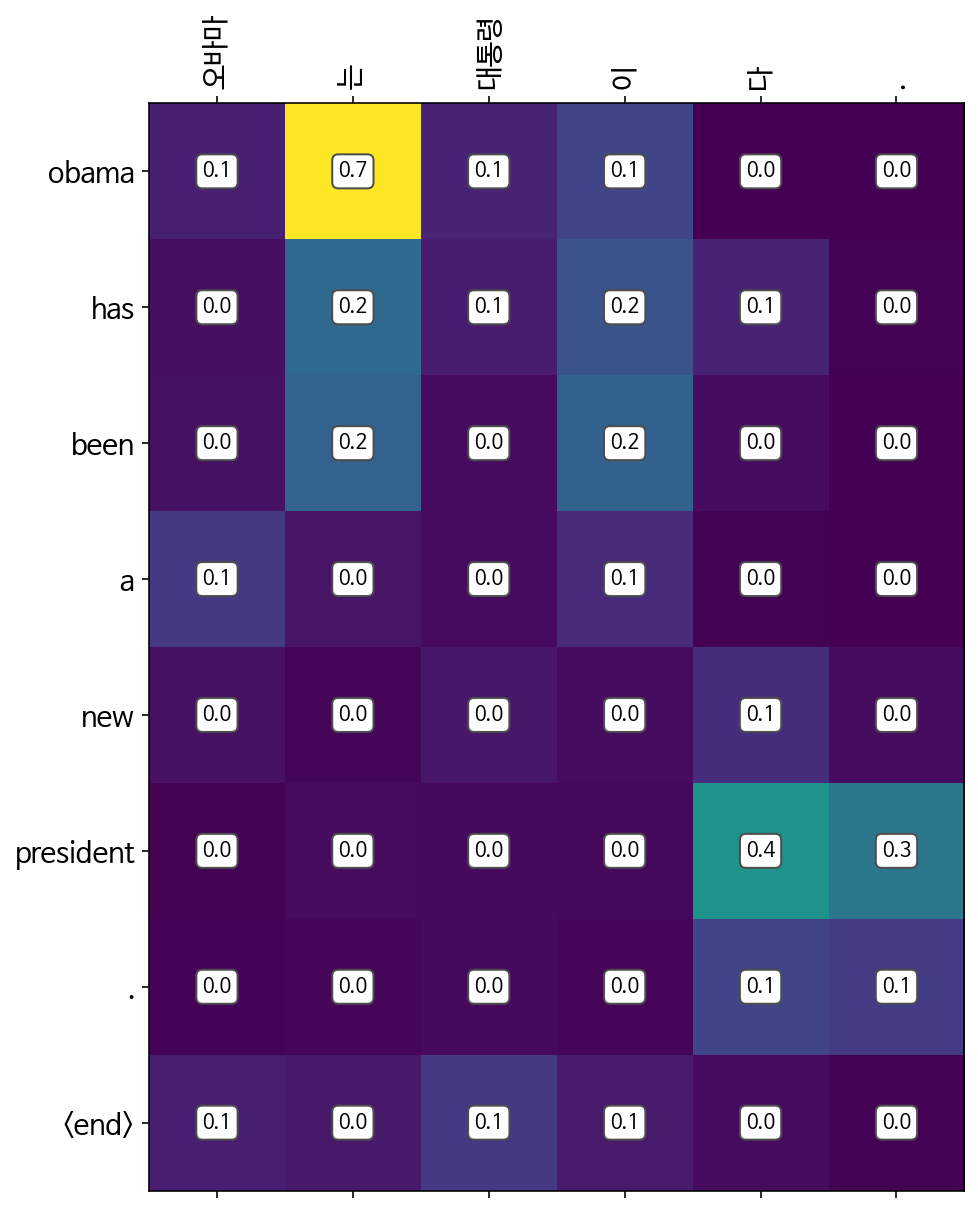

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they are being a . <end> 


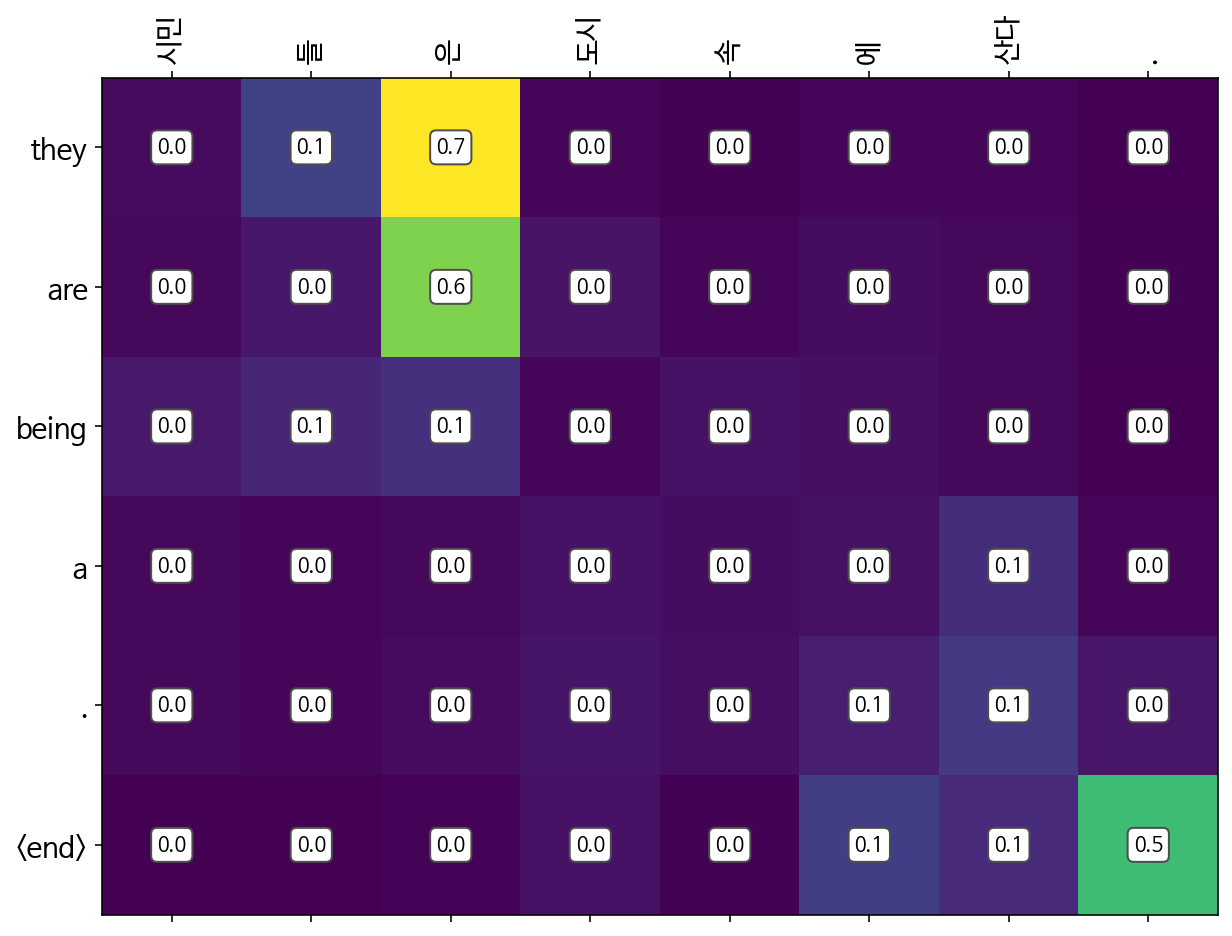

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the problem is not a lot of the same time . <end> 


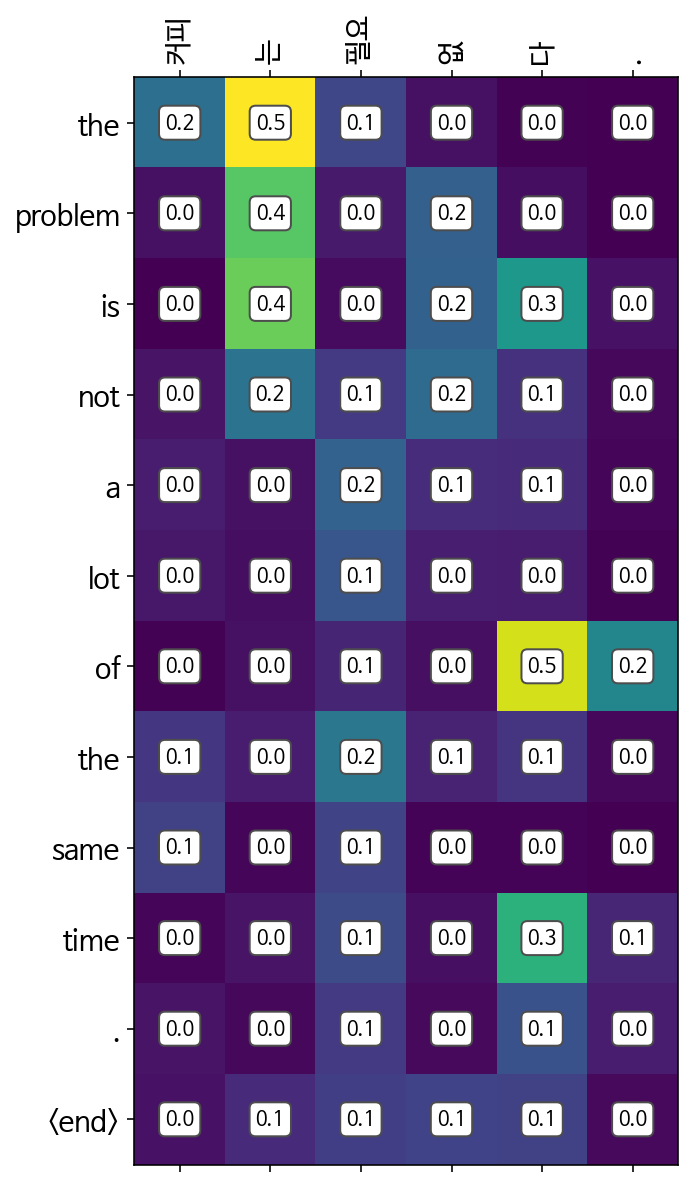

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the dead were killed . <end> 


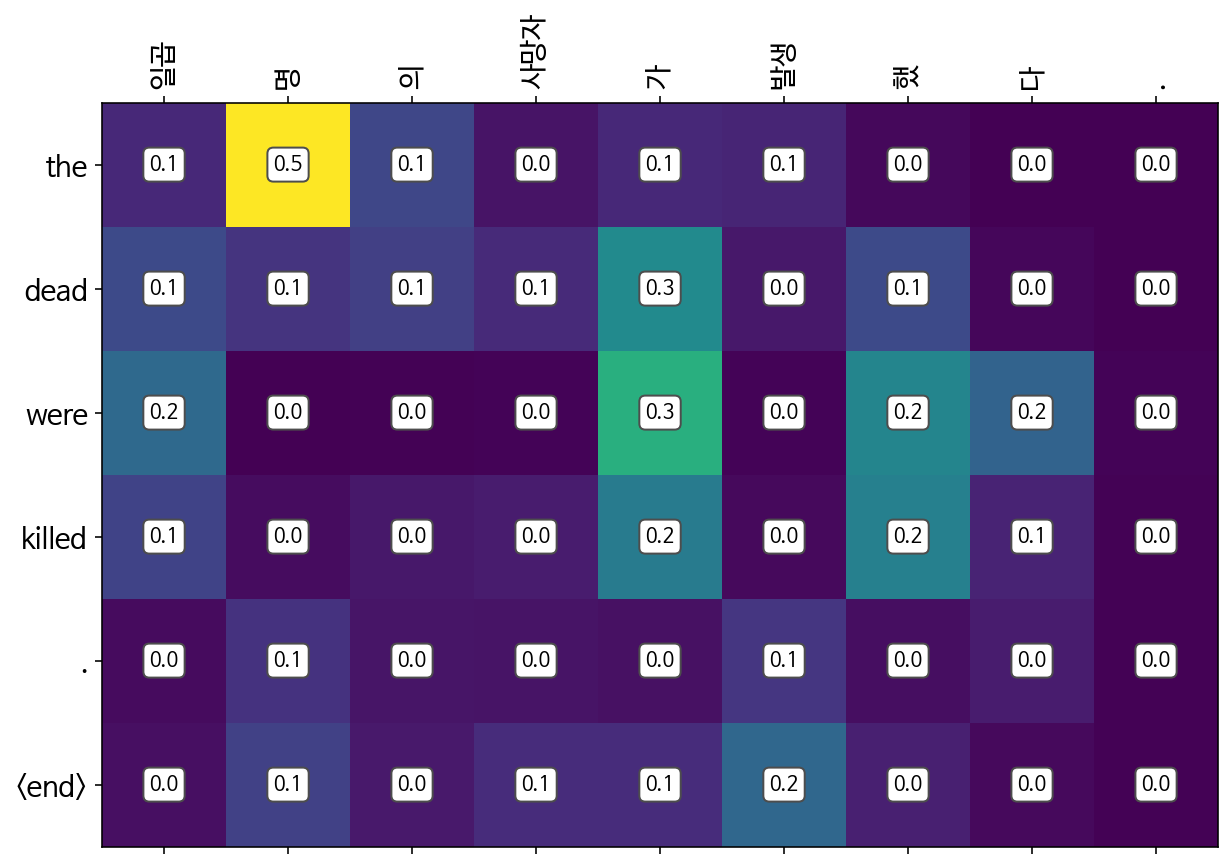

In [38]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

EPOCHS = 15

/tmp/ipykernel_1059/2798138708.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_1059/2798138708.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the president of his job . <end> 


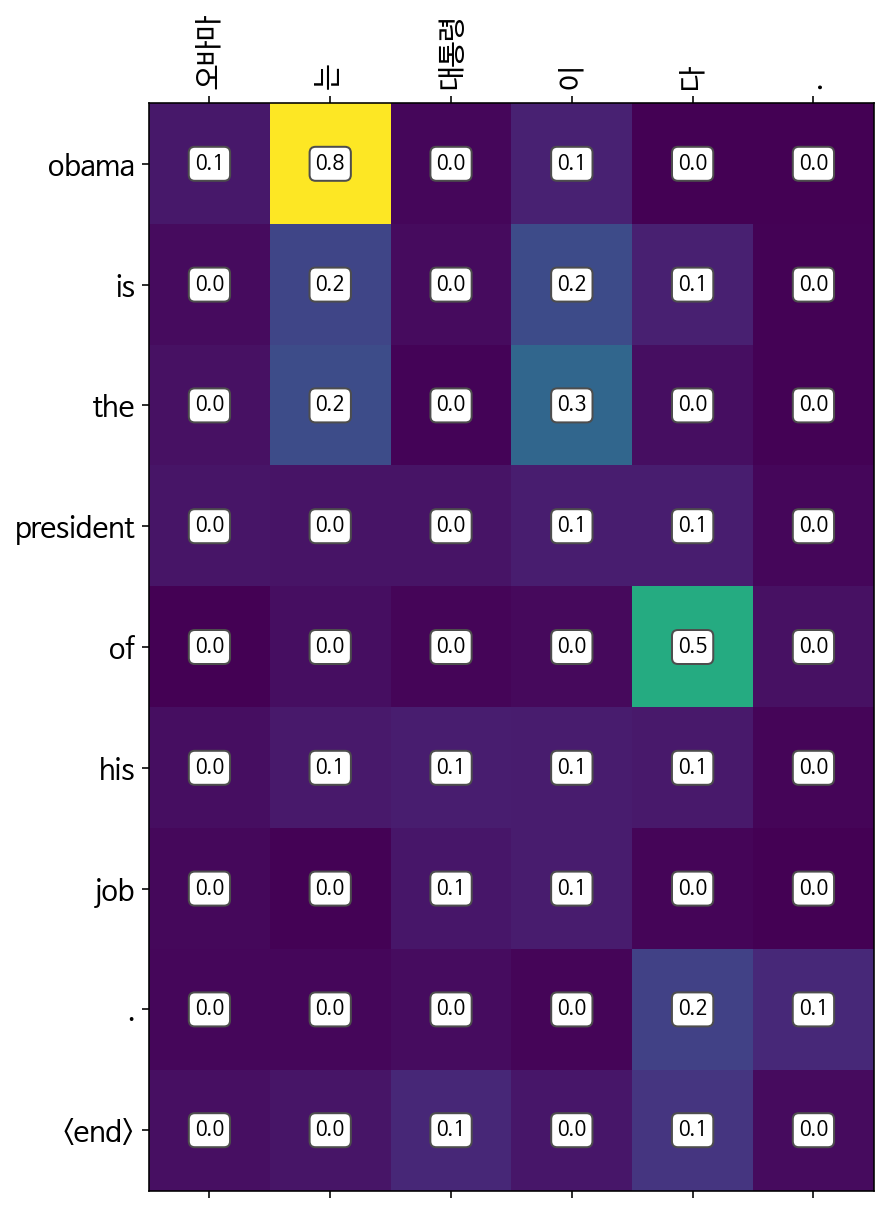

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they have been a <unk> in the city . <end> 


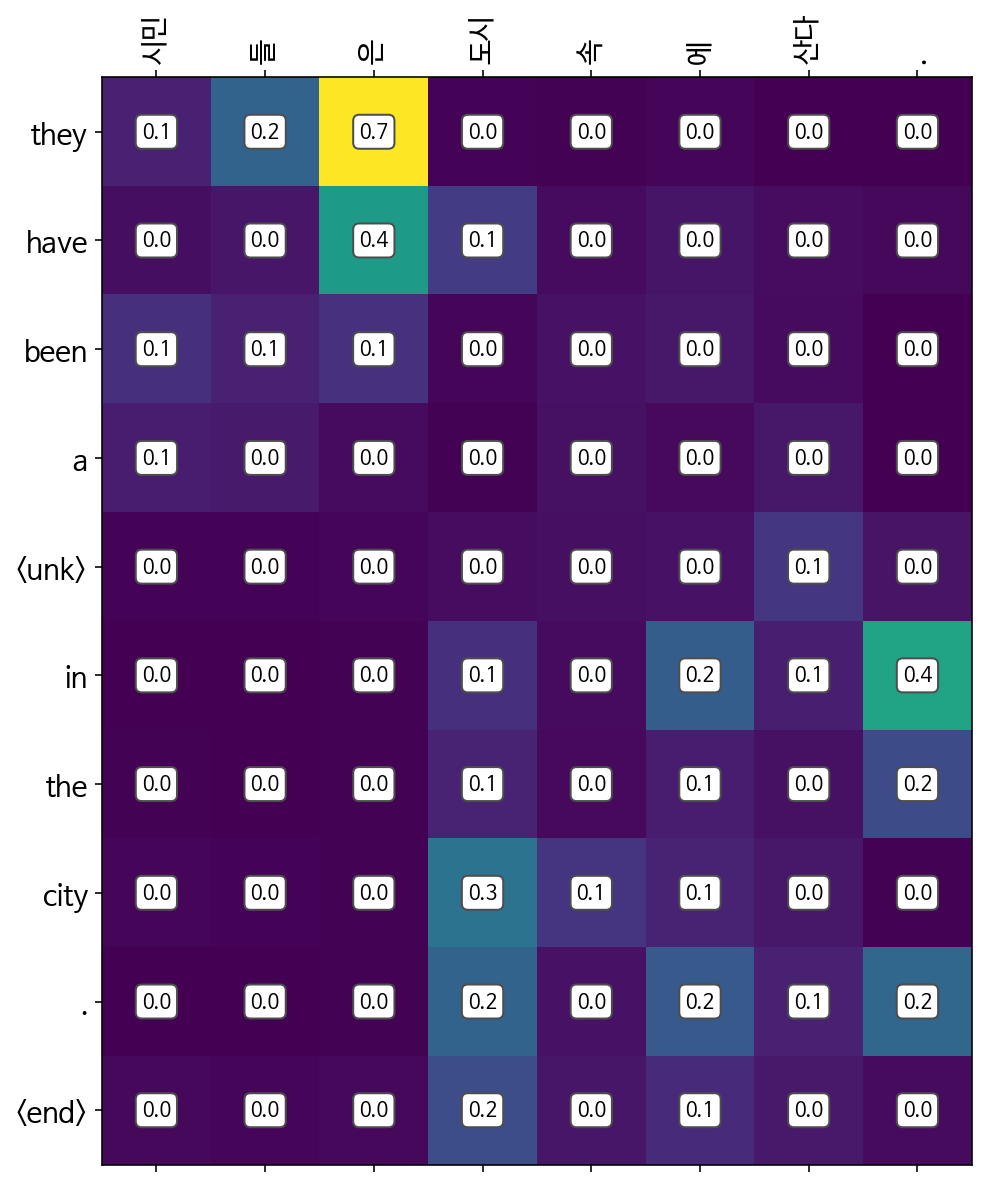

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: you can be a day . <end> 


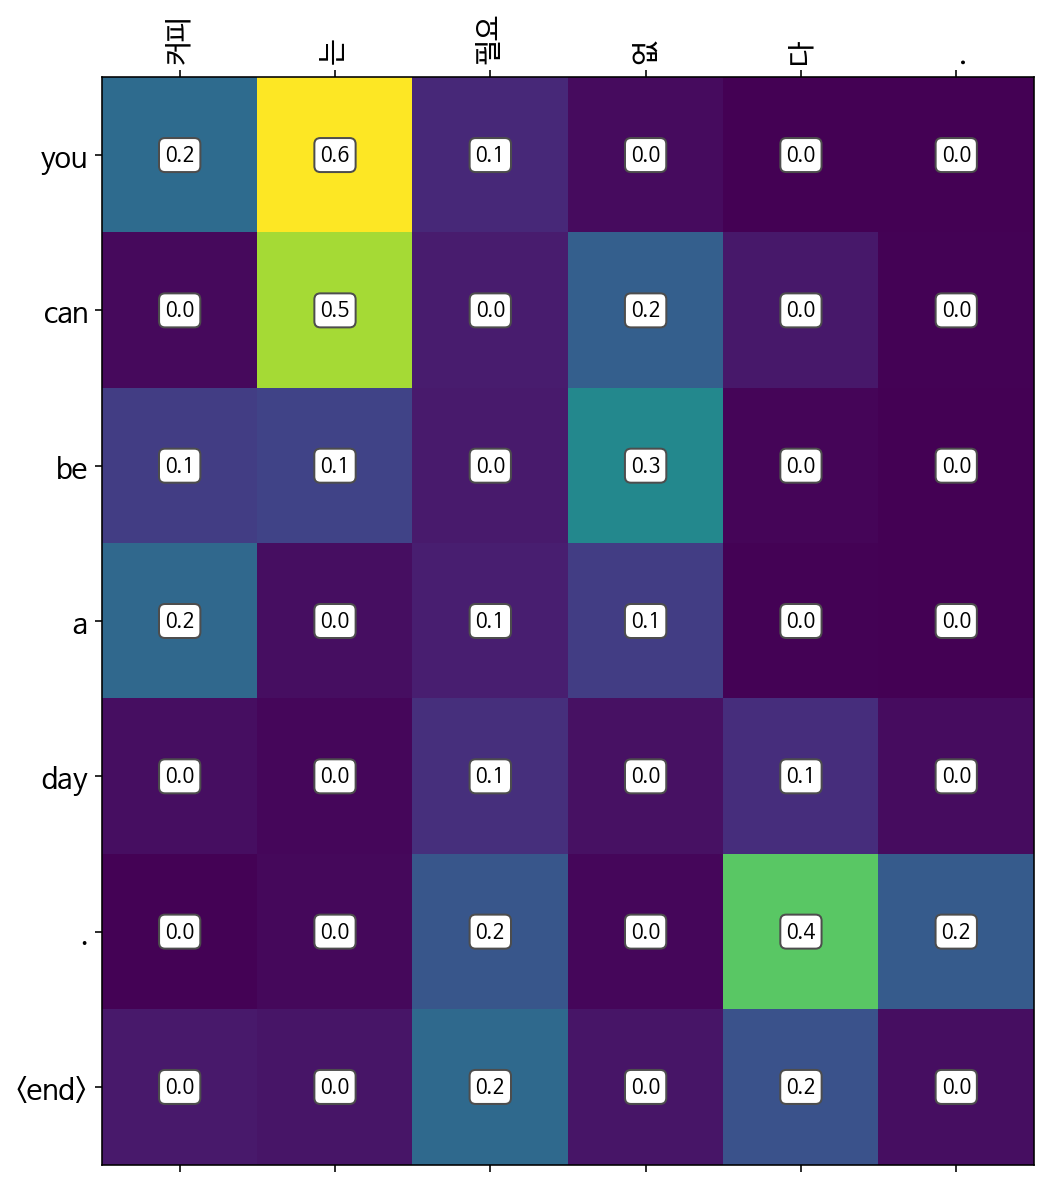

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the dead were killed . <end> 


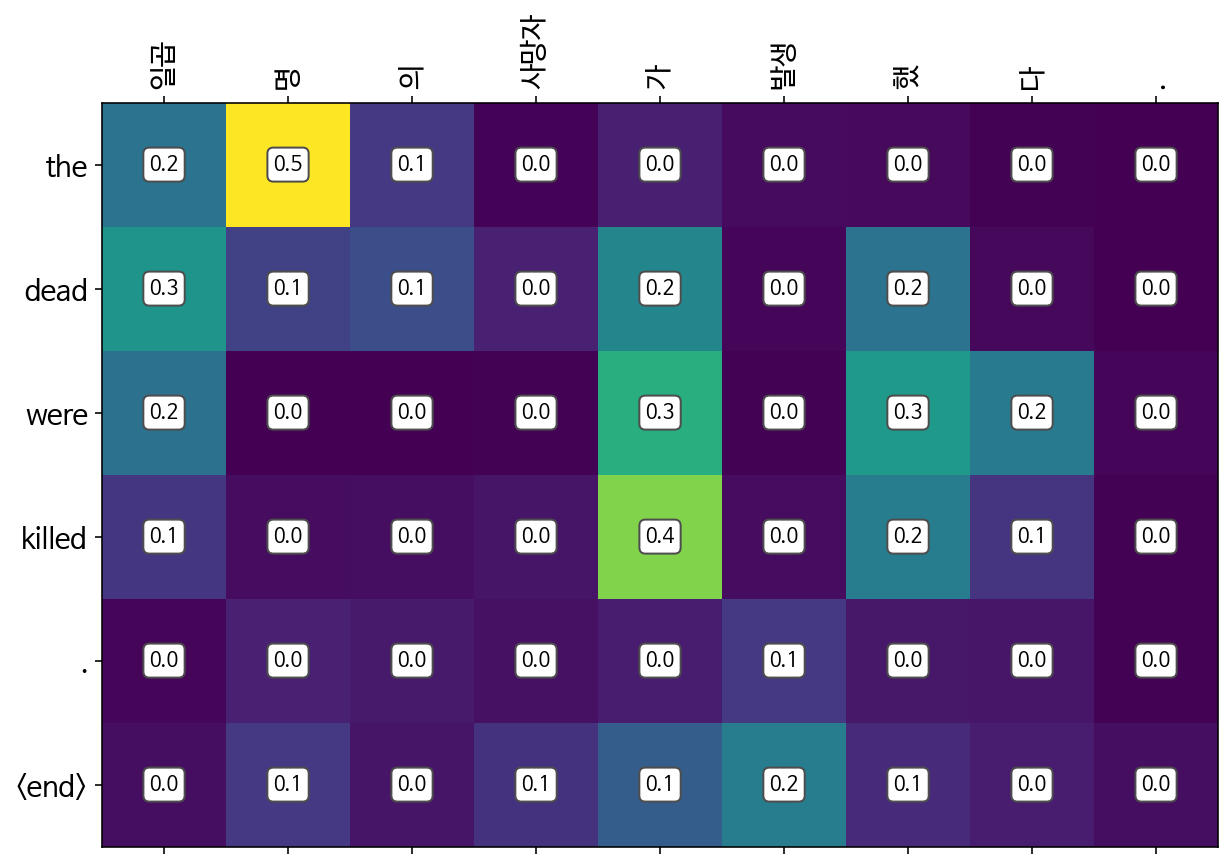

In [41]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

### Epoch = 16

/tmp/ipykernel_1059/2798138708.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_1059/2798138708.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is a president . <end> 


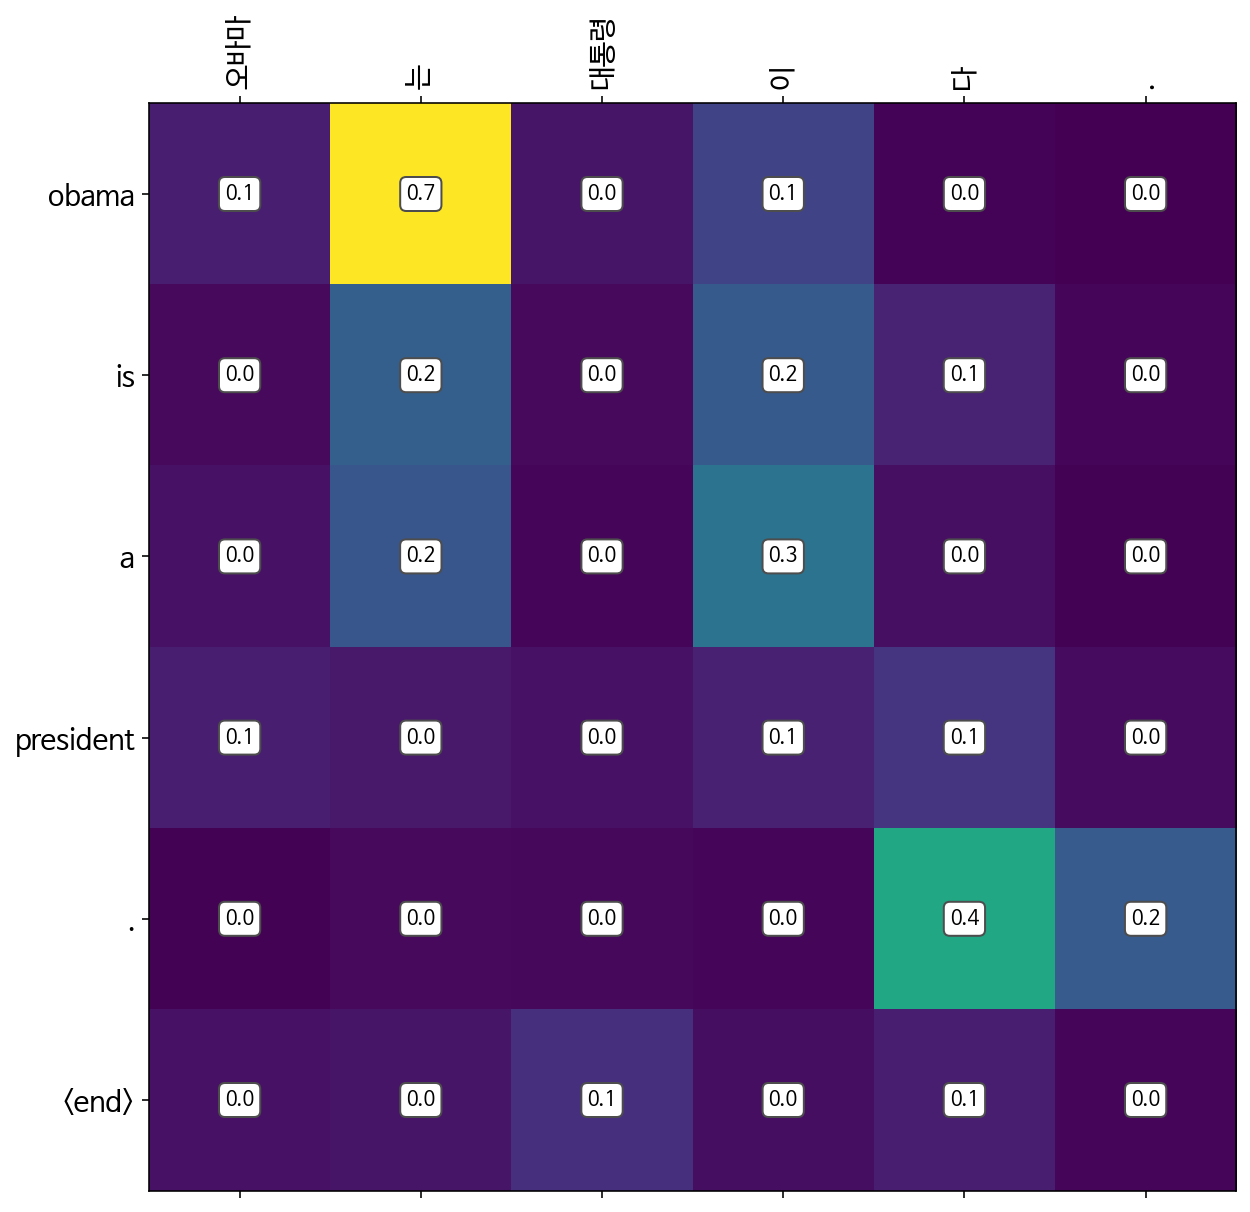

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they have been a city in the city . <end> 


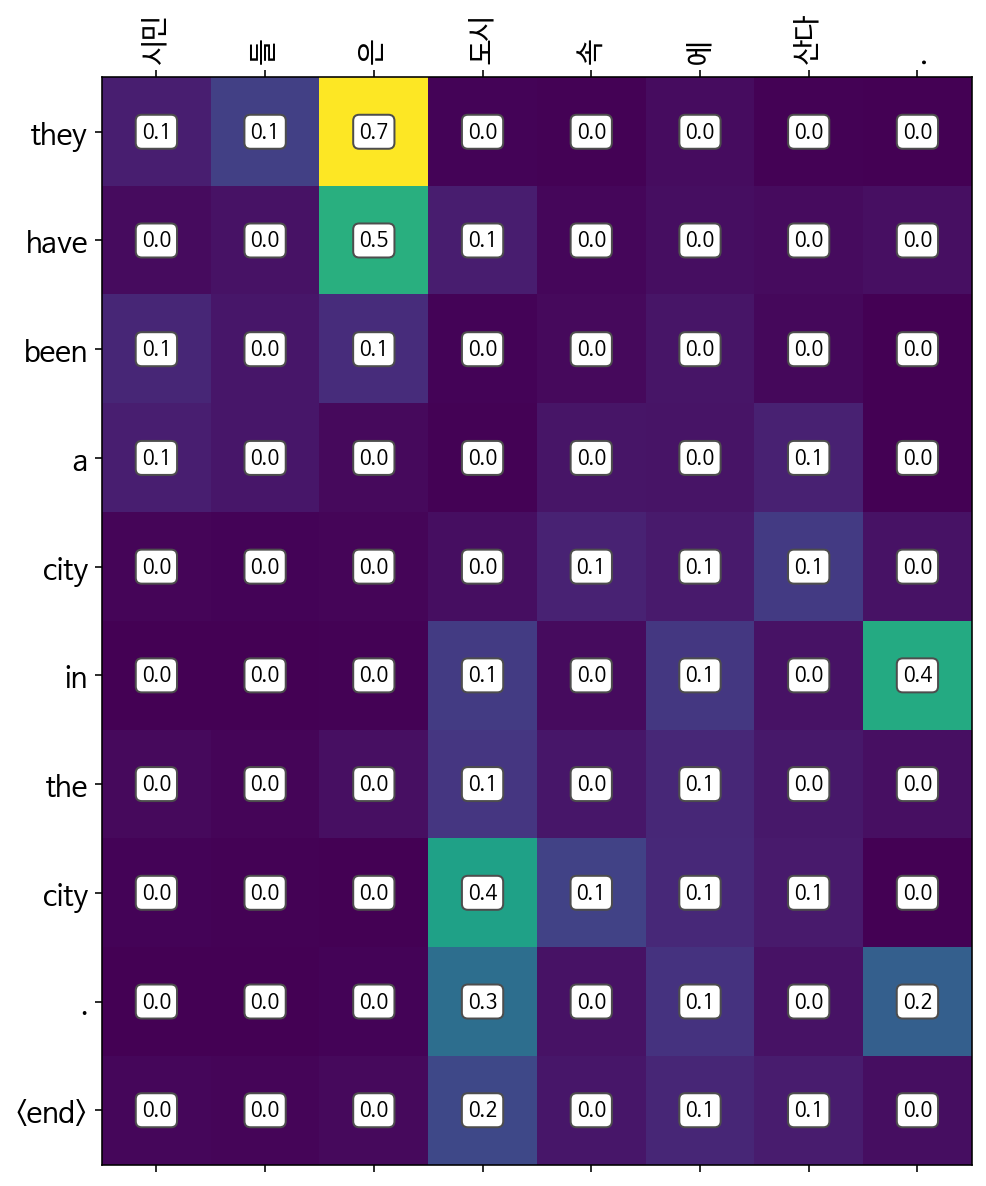

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: you can be a good thing <end> 


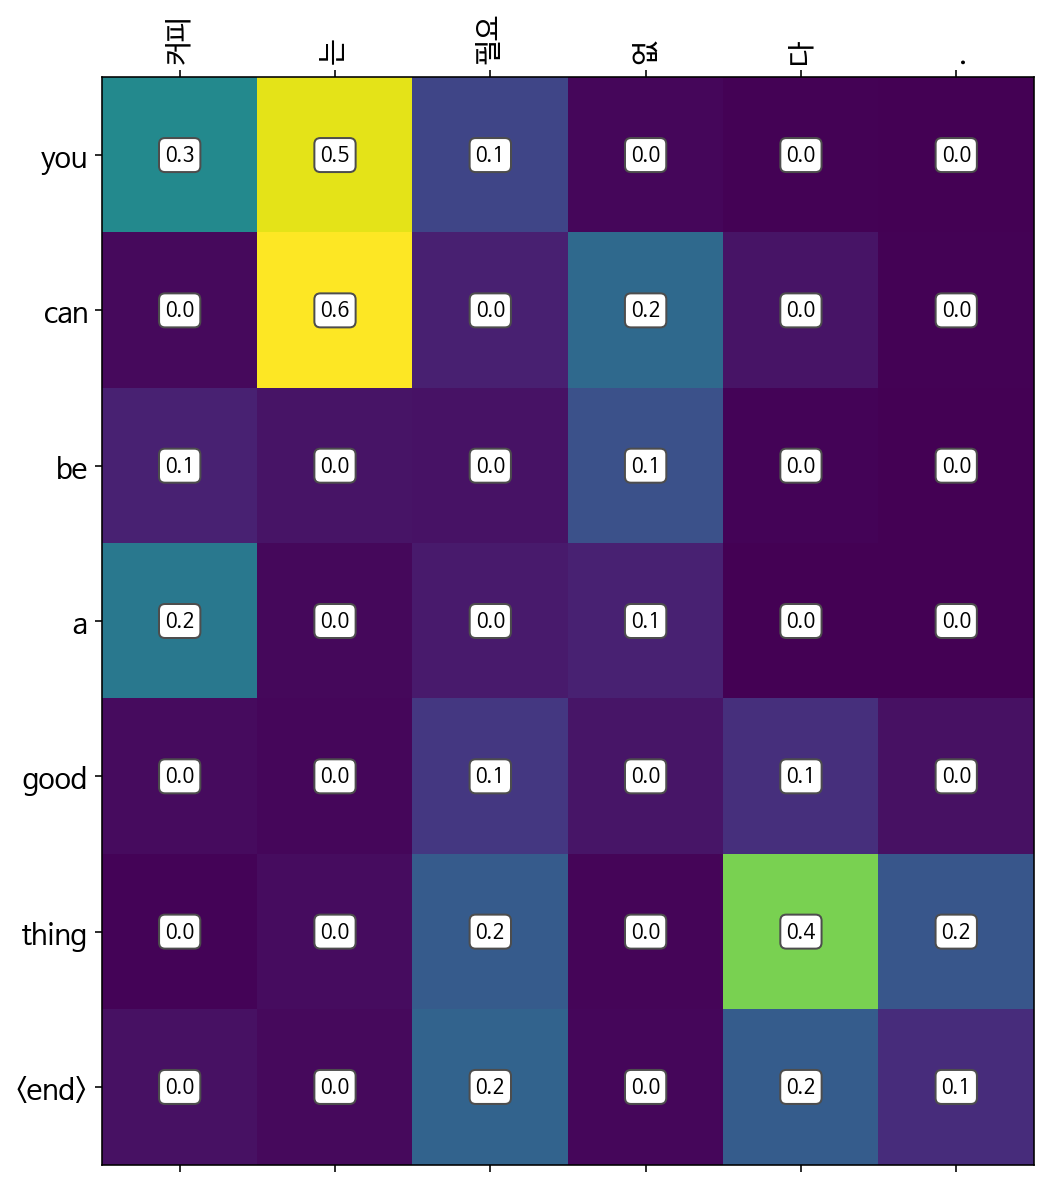

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: one of the dead was killed . <end> 


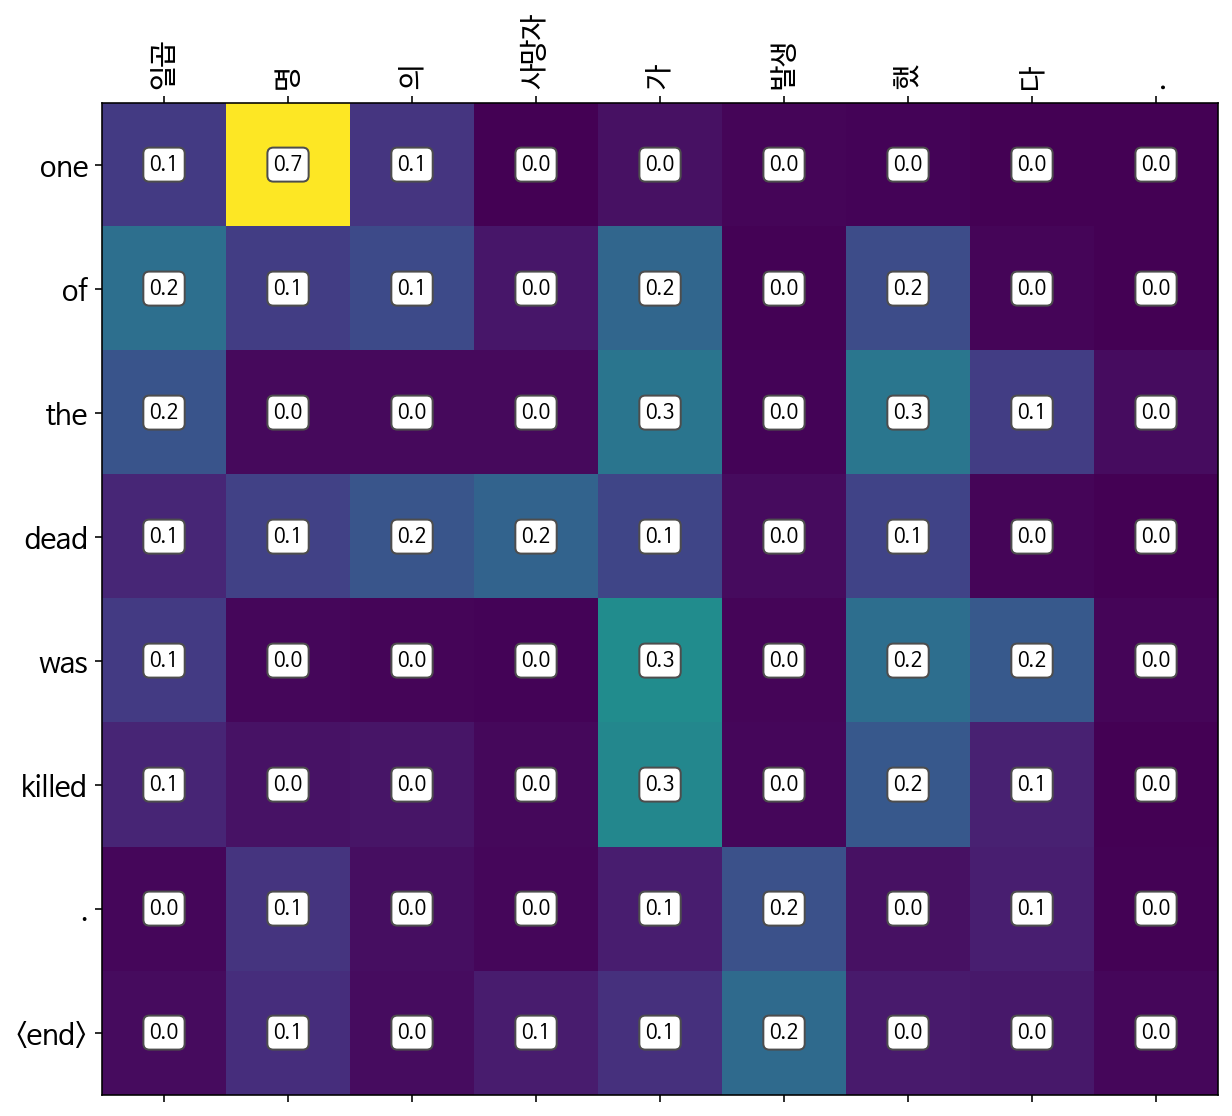

In [44]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

###  Epoch = 17

/tmp/ipykernel_1059/2798138708.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_1059/2798138708.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the president is a new president . <end> 


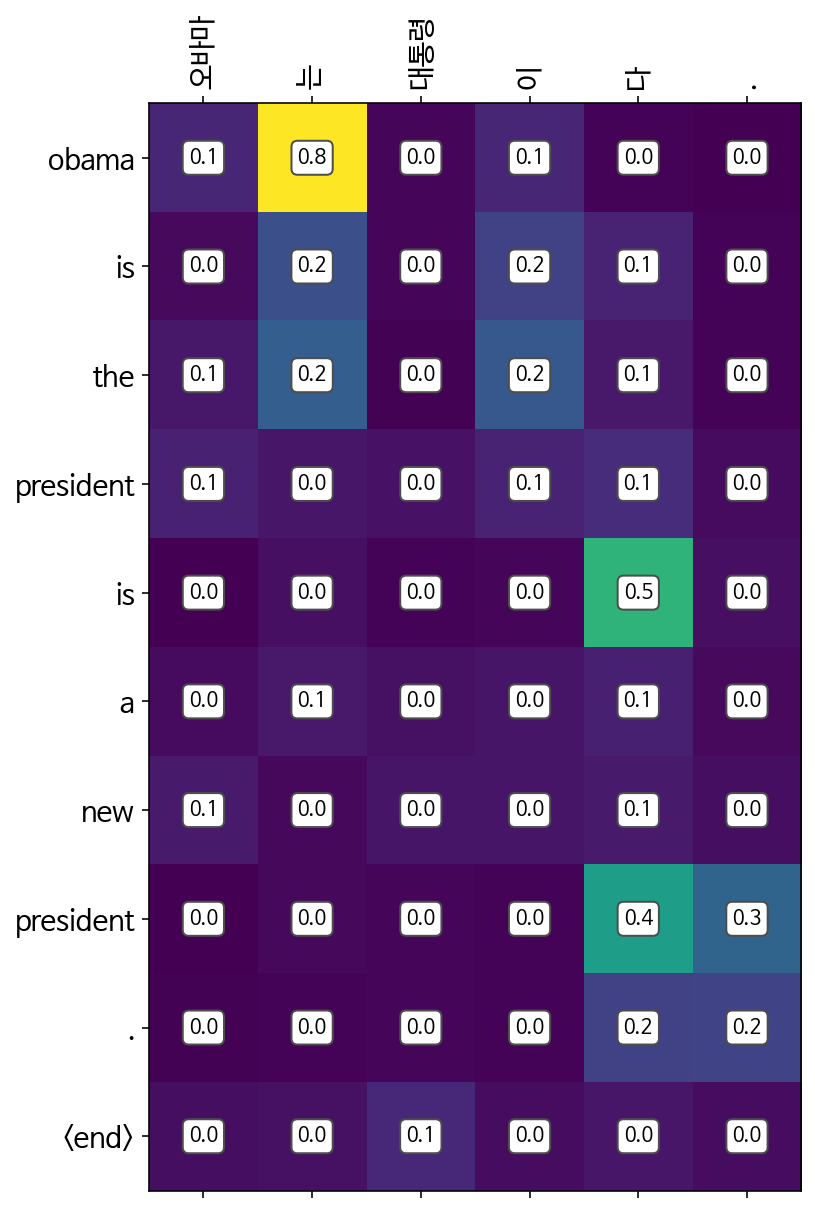

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the group says . <end> 


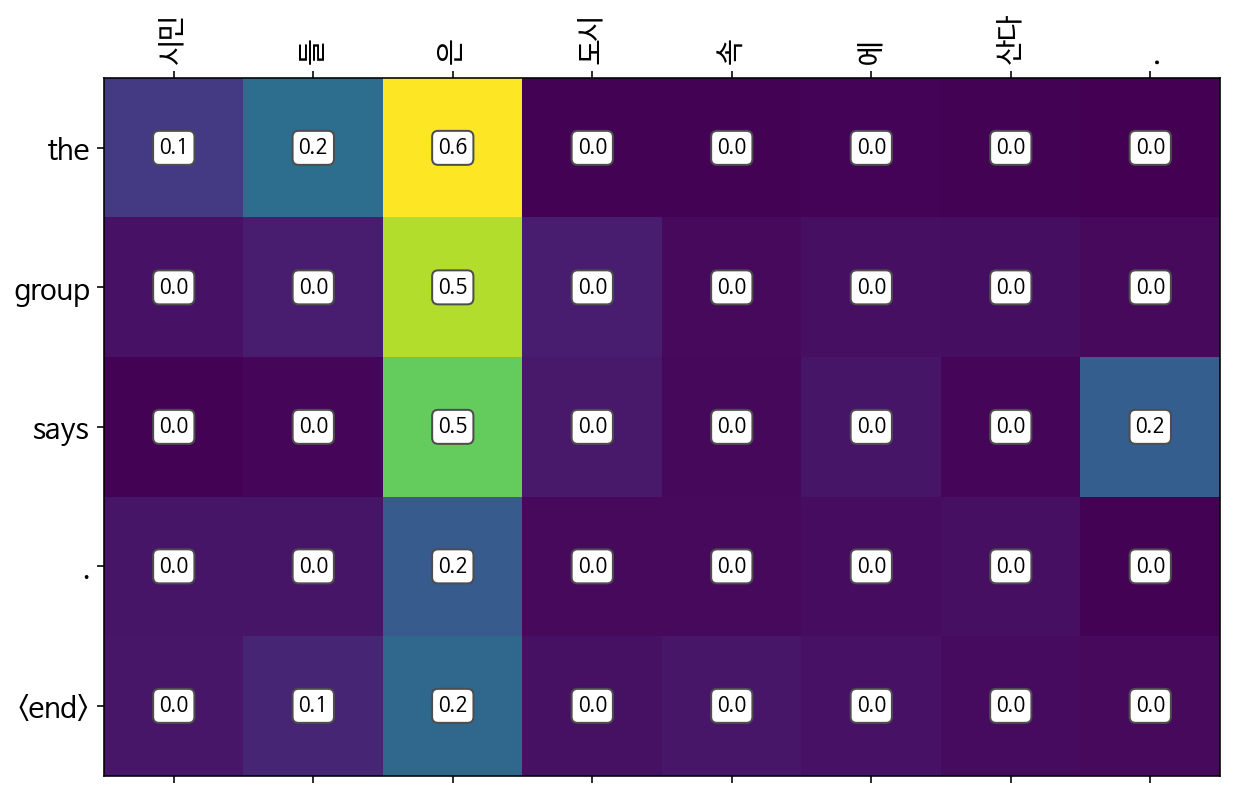

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: you can be coffee <end> 


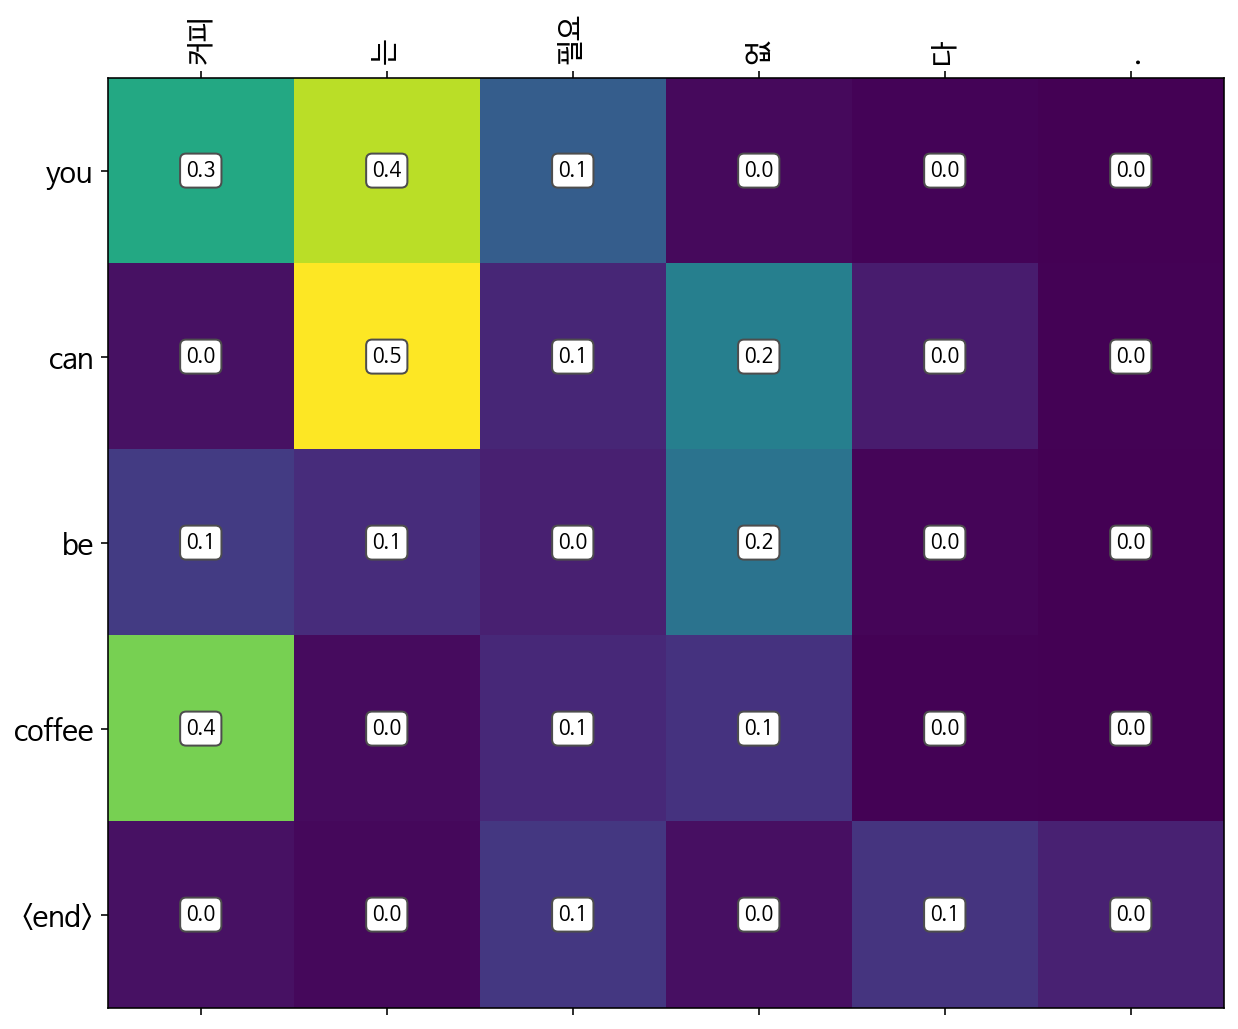

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: one of the dead were still missing . <end> 


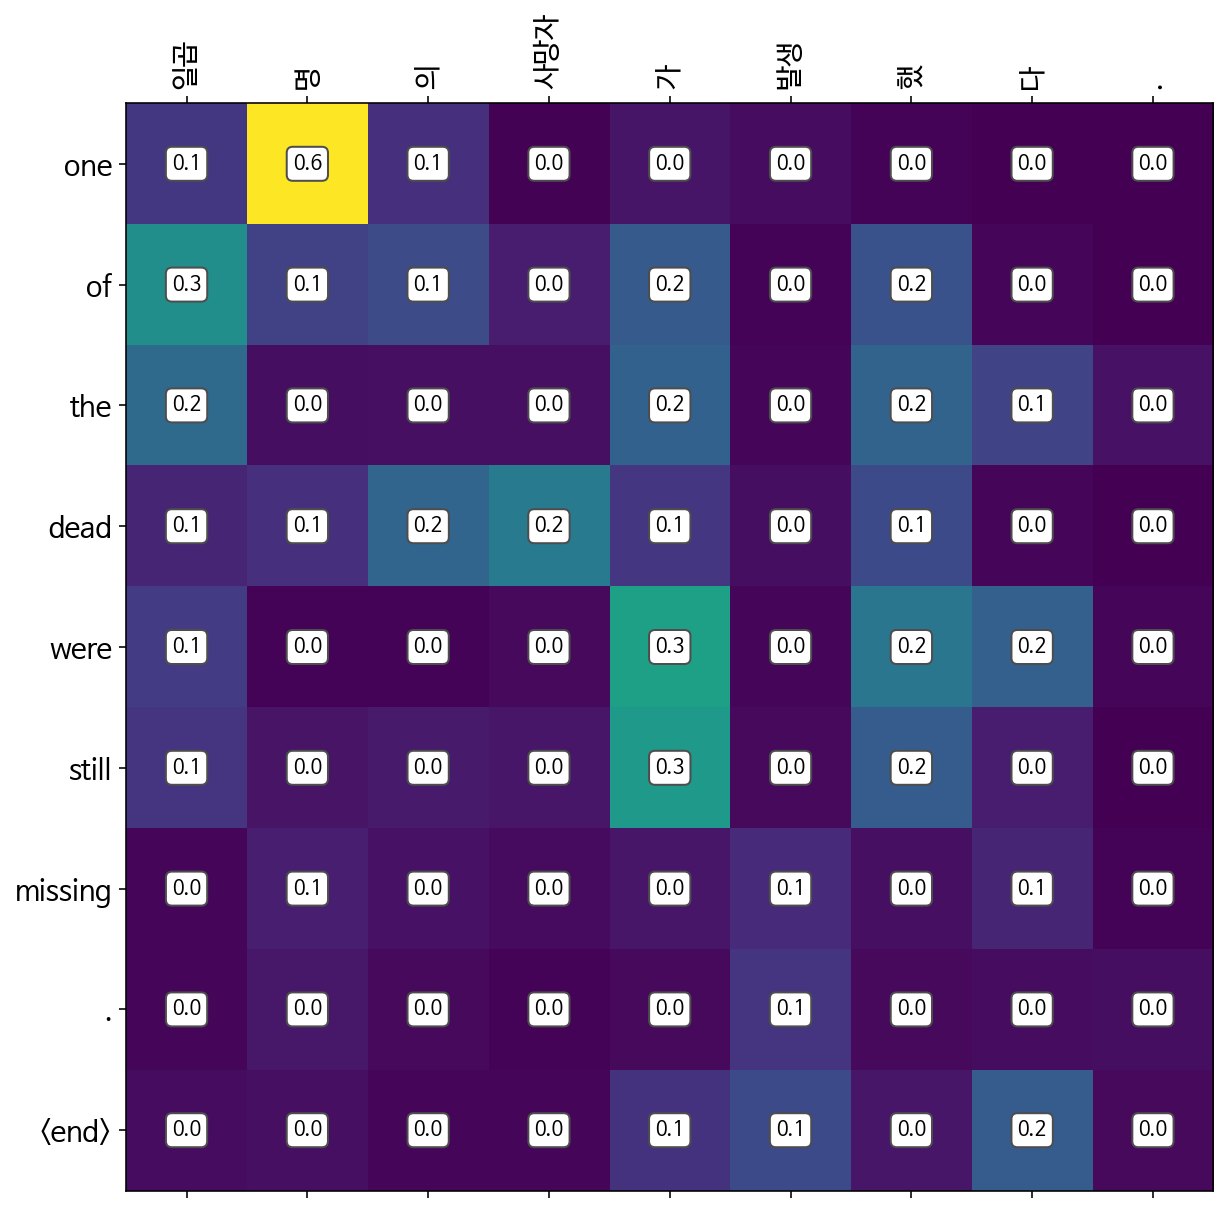

In [46]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

### Epoch = 18

/tmp/ipykernel_1059/2798138708.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_1059/2798138708.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is a president . <end> 


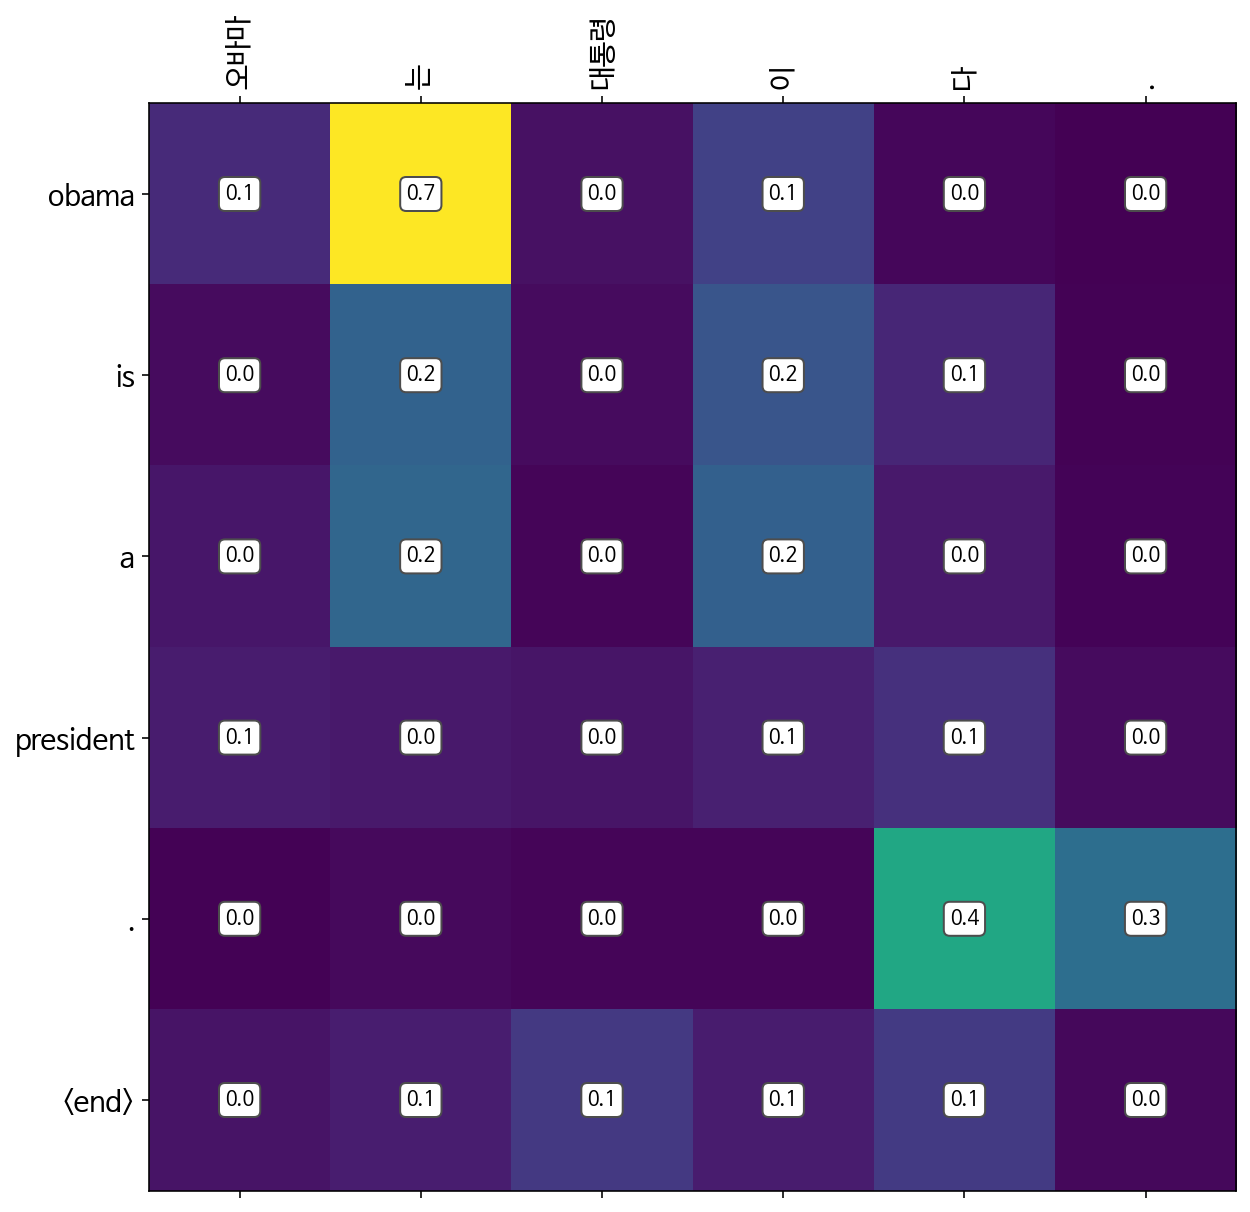

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: many people are being a town in the city . <end> 


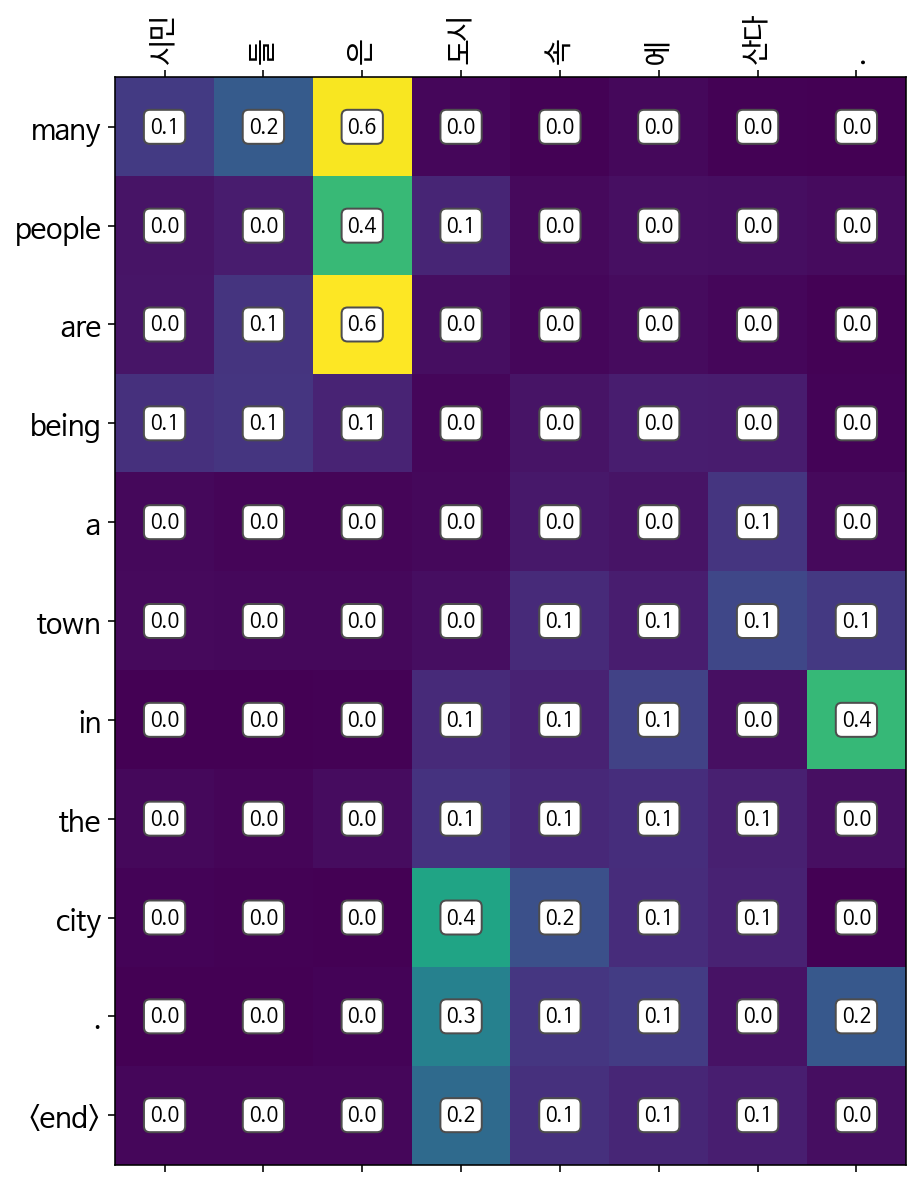

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: you cant get your <end> 


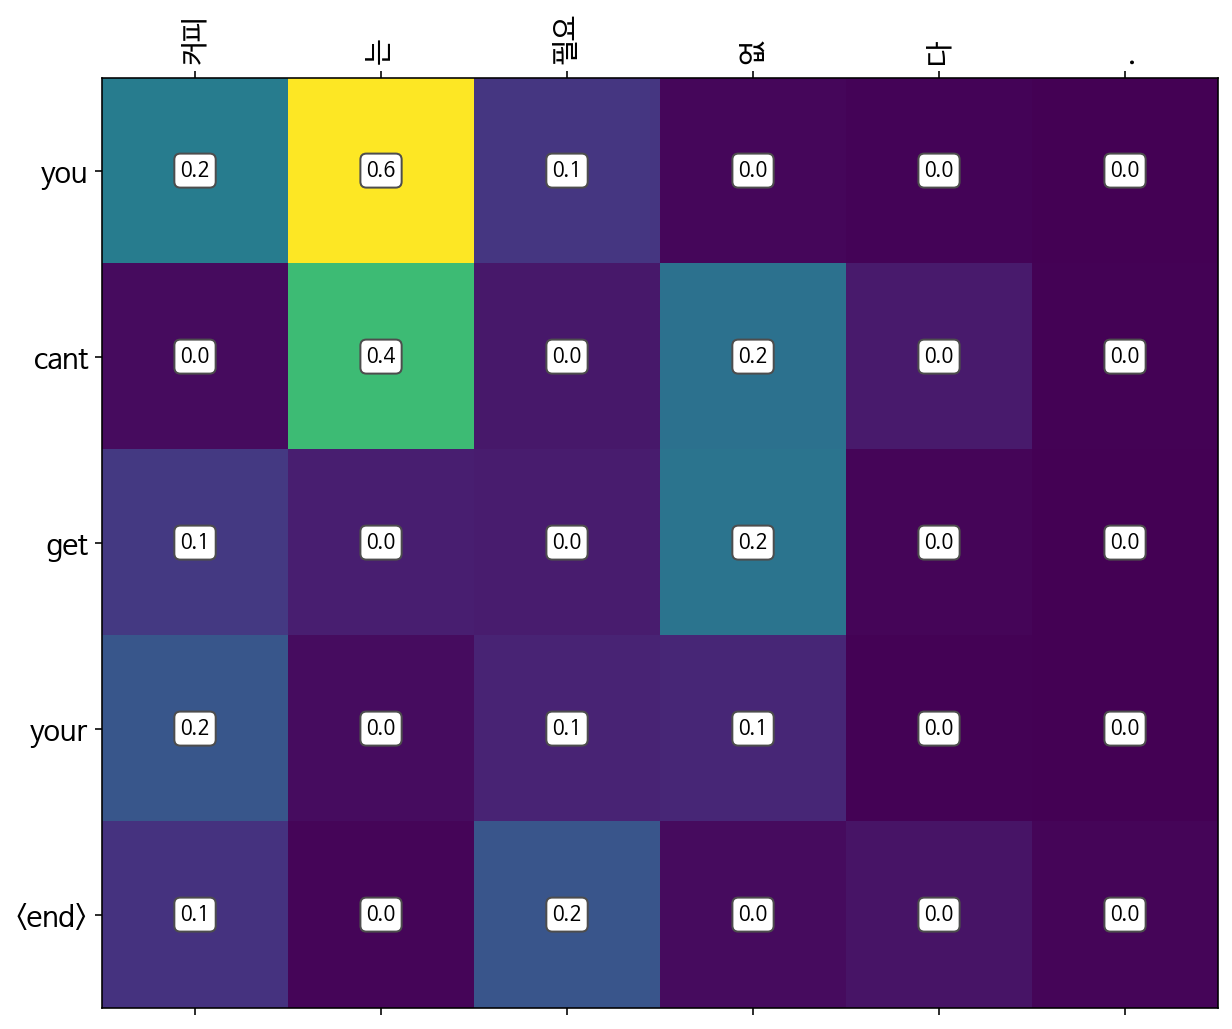

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: more than people died of the dead . <end> 


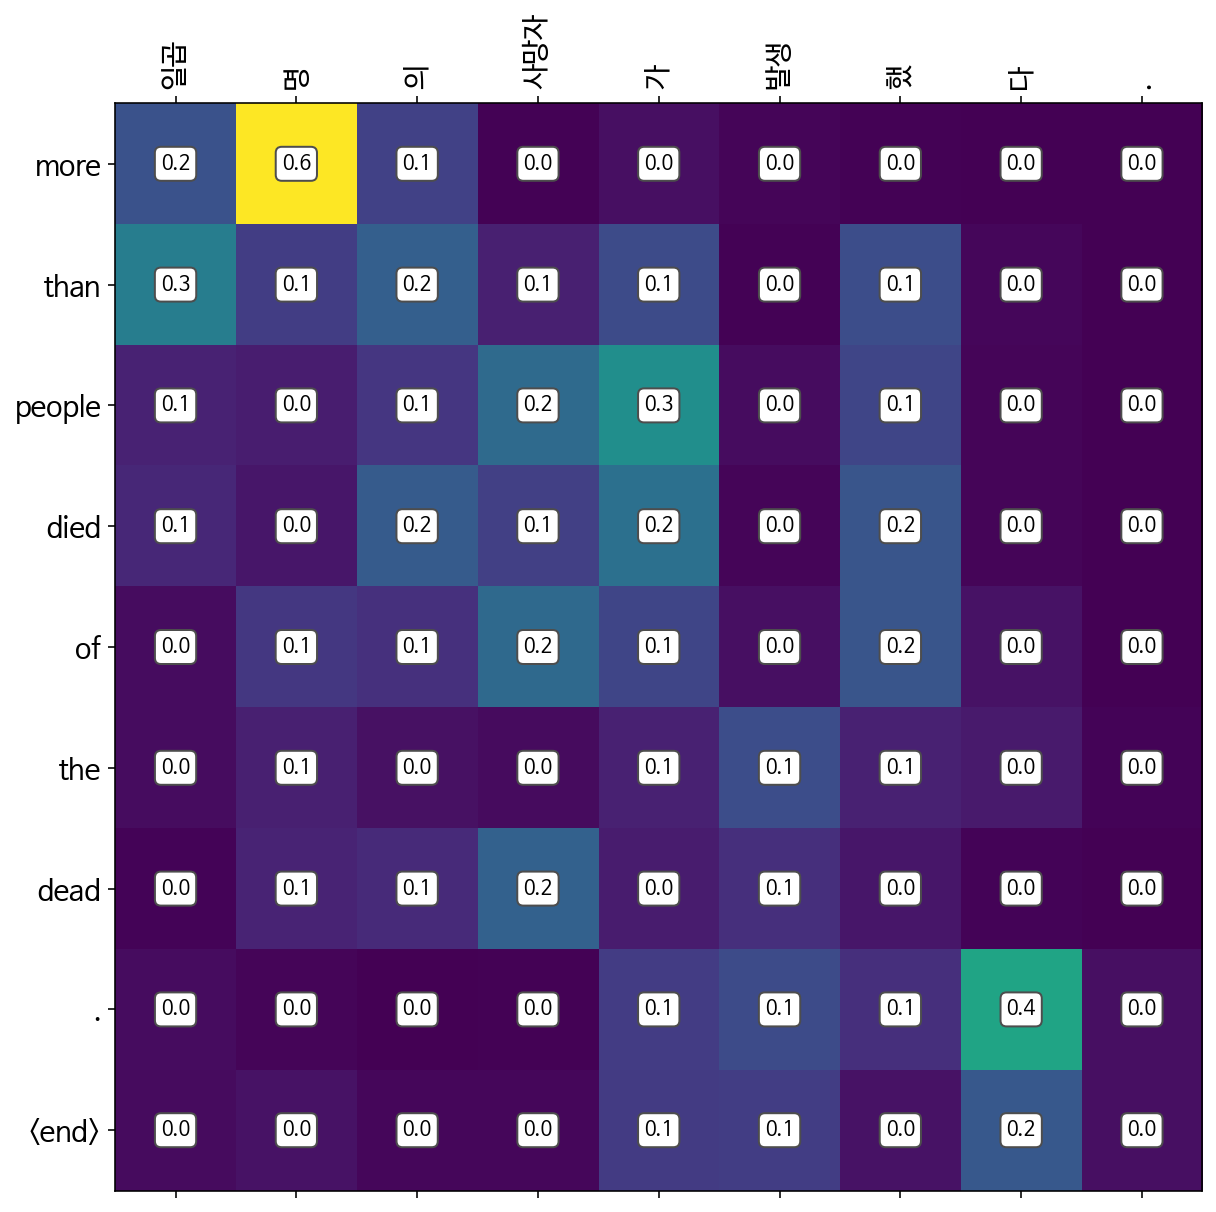

In [48]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

## 회고

* dataset 구성
  train + test data   
  test loss를 보기 위해서 test data 추가시킴  
* 토큰 길이 50 이하인 문장으로 훈련시켰음  
  토큰 길이 40 이하인 문장으로 훈련 시켰을 때, train loss가 잘 떨어지지 않음
* vocab_size = 40000 
* Hyper prameter
  * units = 512
  * embedding_dim = 256
  units = 1024, embedding_dim = 512 로 설정했을때, train loss가 잘 떨어지지 않음  
  drop out 포함 시에도 train/test loss가 떨어지지 않음 
  